<a href="https://colab.research.google.com/github/kfrancis2017/csce556-labs/blob/main/CSCE556_Lab2_NumPy_no_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCE 556 - Analysis of Experimental Data in Python

## Laboratory 2 - Numpy

In this laboratory, we will explore how Numpy can help us manipulate data using an electroencephalogram (EEG) recording. EEG is collected by placing electrodes on the head of a subject. Each electrode samples the local electrical potential at a given rate (typically, somewhere between 100-1000 Hz).

<img src="https://live.staticflickr.com/1711/24169673414_f027e4d8c3_b.jpg">

The number of electrodes can vary from a single electrode to a high-density grid with 256 channels. The activity recorded by such a system looks like that:

<img src="https://images.squarespace-cdn.com/content/v1/56530999e4b0991ab31b67b1/1505831018942-L1E8IHQZ3DUF84PE92VK/EEG_signal.jpg?format=1000w">

For this lab, we will use a recording from an open-access dataset available on <a href="https://openneuro.org/datasets/ds002718/versions/1.0.5">OpenNeuro</a> and published in a <a href="https://www.nature.com/articles/sdata20151">paper of the Scientific Data journal</a>. In this experiment, the participants were presented with faces of famous personalities, of unknown persons, or with scrambled faces. Here is an example of the stimuli used.

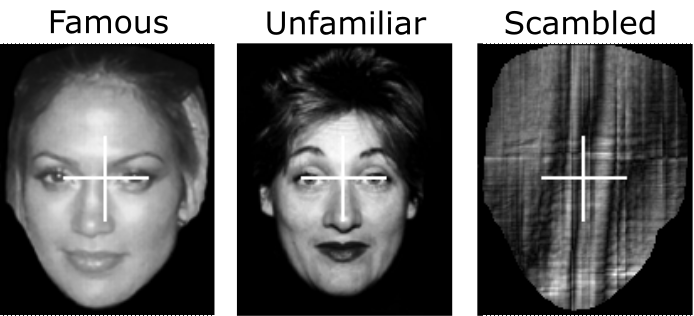


### Installing MNE-Python to work with EEG

In [127]:
!pip install -q mne mne-bids

###Installing openneuro-py to download a sample dataset

In [128]:
!pip install -q openneuro-py

### Downloading the EEG file from OpenNeuro

In [129]:
import openneuro as on

on.download(dataset='ds002718', target_dir='ds002718',
            include='sub-002/**/sub-002_task-*.set',
            verify_hash=True)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002718 …


📁 Traversing directories for ds002718 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 6 files (5 concurrent downloads). 
✅ Finished downloading ds002718.
 
🧠 Please enjoy your brains.
 


Before running the following code, you need to wait for Colab to refresh its file system. Wait until you see the following file available:

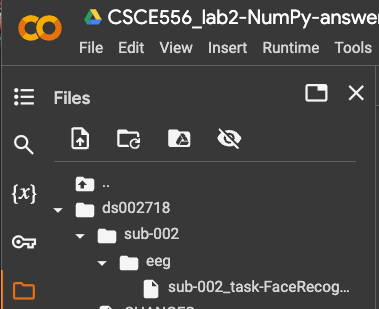

### Epoching the EEG

Epoching is the process by which a continuous recording is split into multiple windows of the same duration, each with a stimulus being presented at time t=0.

In [130]:
import mne
from mne_bids import read_raw_bids, BIDSPath


kwargs = dict(root="./ds002718", subject="002", datatype="eeg",
                task="FaceRecognition")
try:
  bids_path = BIDSPath(**kwargs)
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
except:
  try:
    # Somehow read_raw_bids sometimes fails...
    raw = mne.io.read_raw_eeglab(f"./ds002718/sub-{kwargs['subject']}/{kwargs['datatype']}/"+
                                 f"sub-{kwargs['subject']}_task-{kwargs['task']}_eeg.set")
  except:
    # If this stil does not work, just download through DropBox...
    import urllib.request
    # https://openneuro.org/datasets/ds002718/versions/1.0.5
    url = "https://www.dropbox.com/s/k3sfqt64y8822ym/sub-002_eeg_sub-002_task-FaceRecognition_eeg.set?dl=1"
    urllib.request.urlretrieve(url, "sub2.set");

    # Don't mind the warnings
    raw = mne.io.read_raw_eeglab("sub2.set", preload=True, verbose=False)

events, event_id = mne.events_from_annotations(raw, verbose=False)
epochs = mne.Epochs(raw, events, event_id, verbose=False);

<ipython-input-130-986eaad126d7>:9: RuntimeWarning: Unknown types found, setting as type EEG:
ekg: ['EEG063', 'EEG064']
heog: ['EEG061']
veog: ['EEG062']
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
<ipython-input-130-986eaad126d7>:9: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
<ipython-input-130-986eaad126d7>:9: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
<ipython-input-130-986eaad126d7>:9: RuntimeWarning: Did not find any events.tsv associated with sub-002_task-FaceRecognition.

The search_str was "ds002718/sub-002/**/eeg/sub-002*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, verbose=False)
<ipython-input-130-986eaad126d7>:9: RuntimeWarning: Did not find any chann

### Creating some NumPy ndarray objects

The code below creates three arrays for `famous`, `scrambled`, and `unfamiliar` faces. Each of these variables is a 3D matrix with the shape `Repetitions X Channels X Time`. It also creates two additional variables: `time` is a 1D array containing the time corresponding to each sample along the dimension `Time`; `channels` is a `list` containing the name of the channels along the dimension `Channels`.

In [131]:
famous = epochs["famous_new"].get_data()
scrambled = epochs["scrambled_new"].get_data()
unfamiliar = epochs["unfamiliar_new"].get_data()
time = epochs.times
channels = raw.ch_names

Using data from preloaded Raw for 150 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 176 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 150 events and 176 original time points ...
0 bad epochs dropped


In [132]:
famous.shape  # Repetitions X Channels X Time

(150, 74, 176)

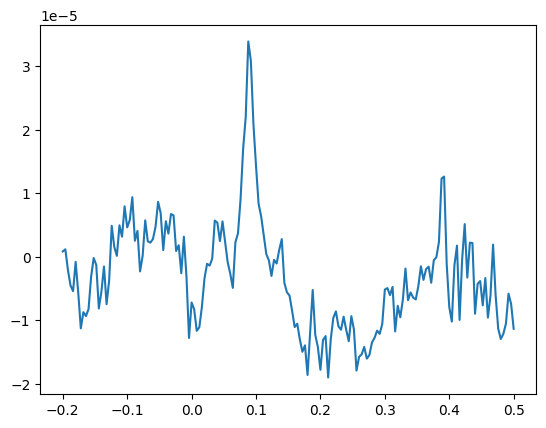

In [133]:
import matplotlib.pyplot as plt
plt.plot(time, famous[0, 0, :])

### Evoked-related potentials (ERP)

An ERP shows the average response of the brain to a stimulus. It is obtained by averaging the brain response across multiple repetitions of a stimulus. (Image from Luck, Woodman, and Vogel (2020))

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S136466130001545X-gr3.jpg">



For example, to obtain the ERP for the "famous faces", the array `famous` needs to be average across its `Repetitions` dimension.

Create three variables `famous_20_erp`, `scrambled_20_erp`, and `unfamiliar_20_erp` that contain the ERP for the channel `EEG020` corresponding to the recording for `famous`, `scrambled`, and `unfamiliar` faces.

In [134]:
#### Add your code ##### (3 lines)
famous_20_erp = famous[:, channels.index("EEG020"), :].mean(axis=0)
scrambled_20_erp = scrambled[:, channels.index("EEG020"), :].mean(axis=0)
unfamiliar_20_erp = unfamiliar[:, channels.index("EEG020"), :].mean(axis=0)
########################

When running the code below, you should obtain the following figure:

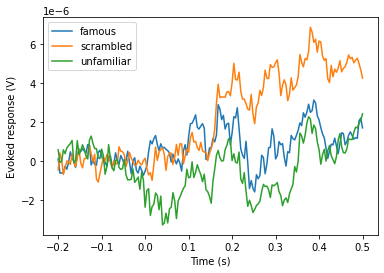

Text(0, 0.5, 'Evoked response (V)')

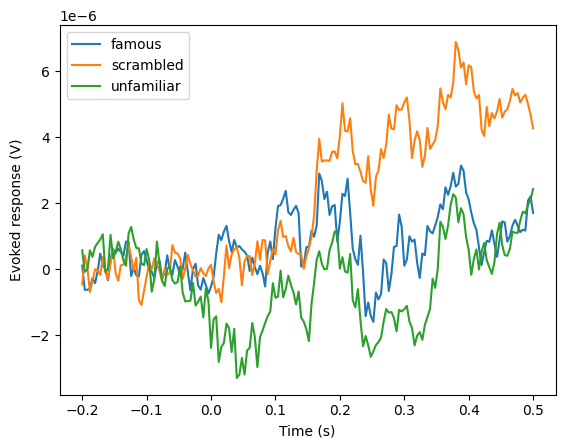

In [135]:
import matplotlib.pyplot as plt

plt.plot(time, famous_20_erp, label="famous")
plt.plot(time, scrambled_20_erp, label="scrambled")
plt.plot(time, unfamiliar_20_erp, label="unfamiliar")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Evoked response (V)")

### Outliers

With experimental recordings (particularly for biosignals), it is not rare to have noisy portions of signals that should be rejected from our analysis. For example, the following code shows all the individual repetitions for the `famous` condition (semi-transparent black lines) and the average across repetitions (red).

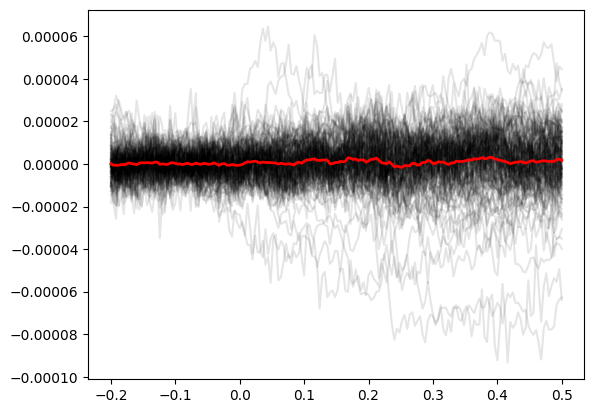

In [136]:
import numpy as np
plt.plot((time * np.ones((famous.shape[0], 1))).T, famous[:, channels.index("EEG020"), :].T,
         color="black", alpha=0.1);
plt.plot(time, famous[:, channels.index("EEG020"), :].mean(0),
         color="red", linewidth=2);

As can be seen, some of these repetitions have large amplitude and do not follow the same patterns as the others. These are statistical outliers that we need to remove. To identify and remove these repetitions from the computation of the ERP, calculate the mean absolute error for the `famous` condition and the channel `EEG020`. This error is defined as $error = mean_t(|x_i(t) - mean_i(x_i(t))|)$, with the first average being across time (t), the second average being across repetitions (i), and $|x|$ representing the absolute value of $x$. The array `error` should have a `shape` `(150,)`, corresponding to the number of epochs. Use `plt.hist(error)` to confirm that you obtain the following distribution:

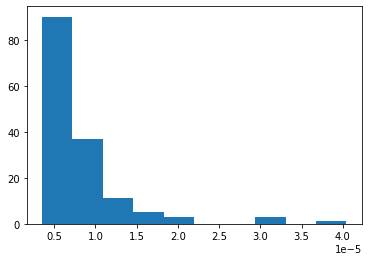

(array([90., 37., 11.,  5.,  3.,  0.,  0.,  3.,  0.,  1.]),
 array([3.52428909e-06, 7.21571805e-06, 1.09071470e-05, 1.45985760e-05,
        1.82900049e-05, 2.19814339e-05, 2.56728628e-05, 2.93642918e-05,
        3.30557207e-05, 3.67471497e-05, 4.04385786e-05]),
 <BarContainer object of 10 artists>)

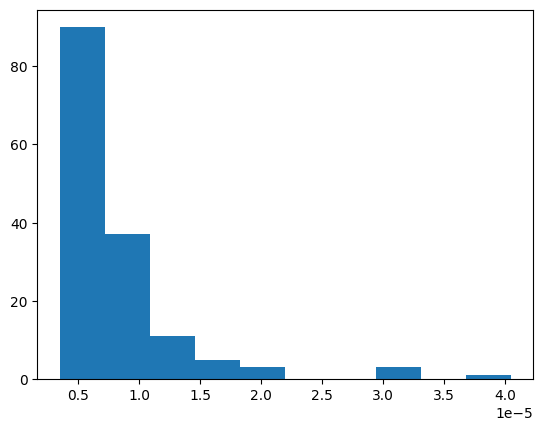

In [137]:
#### Add your code #### (3-5 lines)
xi_t = famous[:,channels.index("EEG020"), :] # shape: (150, 176)
error = np.abs((xi_t-famous_20_erp)).mean(axis=1)

plt.hist(error)
#######################

We can identify noisy epochs as those having an error larger than $Q_3 + k(Q_3 - Q1)$, where $Q_3$ and $Q_1$ are the third and the first quartiles (i.e., 75 and 25 percentiles) of the distribution of errors and `k` is a coefficient, often set to 1.5. Use this criterion (with `k=1.5`) to find which epochs (repetitions) are outliers. You can use `numpy.percentile()` to compute the value of $Q_3$ and $Q_1$ (see the documentation online of using `help(numpy.percentile)` or `?numpy.percentile`). Create a new variable `famous_20_erp_clean` that computes the ERP for the `famous` conditions and the channel `EEG020` using only the epochs that are not considered outliers.

In [138]:
#### Add your code #### (4-5 lines)
import numpy as np
Q3 = np.percentile(error, 75)
Q1 = np.percentile(error, 25)

thresh = Q3 + 1.5*(Q3-Q1)
famous_20_erp_clean = famous[:, channels.index("EEG020"), :][error < thresh].mean(axis=0)
#######################

Using the code below, confirm that you obtain the fellowing result:

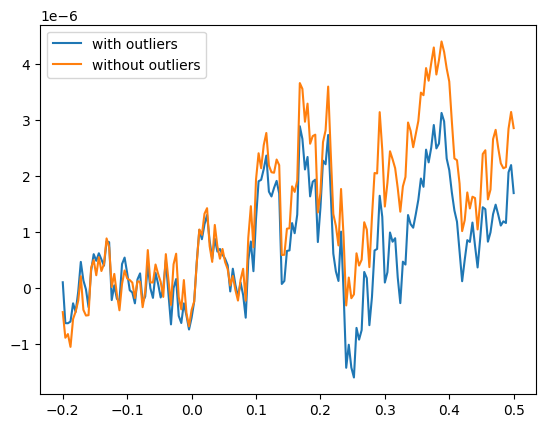

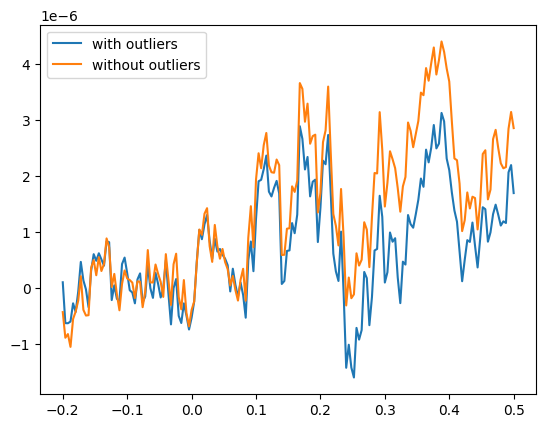

In [139]:
import matplotlib.pyplot as plt

plt.plot(time, famous_20_erp, label="with outliers")
plt.plot(time, famous_20_erp_clean, label="without outliers")
plt.legend()

# Submission

Please submit a .ipynb file containing your answers in Blackboard. A simple way to generate such a .ipynb file from a Colab Notebook is to click File --> Download --> Download .ipynb. This .ipynb file will need to be added as an attachment to your submission. The deadline to submit your lab is specified on Blackboard. Late submissions are penalized 20% per day, as per the syllabus.